# Mistake analysis

Force models to output past end-of-sequence token (`$`) be modyfing its logit directly, or by shifting the positional encoding indices of the answer generated so far to force. Aim is to see if they can correctly predict the answer digits in OOD positions. If yes, then it could be that the position-dependent circuit decides to stop the generation by outputting the EOS token and not the addition circuit itself failing.

In [1]:
import re
import random

from Levenshtein import distance
import torch
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import seaborn as sns
import pandas as pd

from arithmetic_lm.model import (
    TransformerDecoder,
    load_model,
    find_latest_ckpt,
    generate,
)
from arithmetic_lm.tokenizer import CharTokenizer
from arithmetic_lm.constants import PLOTS_DIR, CHECKPOINTS_DIR

import warnings

warnings.filterwarnings("ignore")

In [2]:
tokenizer = CharTokenizer()
stop_token = tokenizer.encode("$")[0]

In [3]:
# load model
model_name = "trans_dec_6layers_768embd_4head_randsp0.5_rev_ansloss"
ckpt_path = "../checkpoints/addition-generalize-to-longer/trans_dec_6layers_768embd_4head_randsp0.5_rev_ansloss/step1000000-train_loss0.0002-val_loss0.0000.ckpt"
model, hparams = load_model(ckpt_path)
model.to("mps")
model.eval()

TransformerDecoder(
  (embedding): Embedding(100, 768)
  (pos_encoder): AbsolutePositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (linear1): Linear(in_features=768, out_features=3072, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=3072, out_features=768, bias=True)
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
    (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=100, bias=False)

In [4]:
print(hparams["extra_hparams"]["data_format"])
reverse_ops = hparams["extra_hparams"]["data_format"]["reverse_ops"]
reverse_ans = hparams["extra_hparams"]["data_format"]["reverse_ans"]

{'pad': '$', 'pad_ops_zero': None, 'pad_ans_zero': None, 'reverse_ops': True, 'reverse_ans': True, 'encdec': False, 'filler_tokens_prompt': 0, 'filler_tokens_ans': 0, 'operand_random_spaces_amount': 0.5, 'chain_of_thought': False}


torch.Size([10, 768])
[0.16363235 0.14307685]


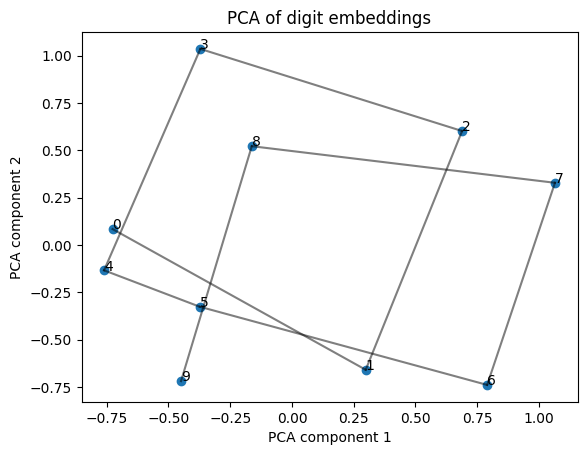

In [5]:
# extract and plot PCA for digit token embeddings
from sklearn.decomposition import PCA

digit_tokens = tokenizer.encode("0123456789")
digit_embeddings = model.embedding(torch.tensor(digit_tokens).to("mps"))
print(digit_embeddings.shape)

pca = PCA(n_components=2)
embedding_pca = pca.fit_transform(digit_embeddings.detach().cpu().numpy())
print(pca.explained_variance_ratio_)

plt.figure()
plt.scatter(embedding_pca[:, 0], embedding_pca[:, 1])
for i, txt in enumerate(digit_tokens):
    plt.annotate(txt, (embedding_pca[i, 0], embedding_pca[i, 1]))
# connect the digits in order
for i in range(10):
    plt.plot(
        embedding_pca[i : i + 2, 0],
        embedding_pca[i : i + 2, 1],
        color="black",
        alpha=0.5,
    )
plt.xlabel("PCA component 1")
plt.ylabel("PCA component 2")
plt.title("PCA of digit embeddings")
# plt.savefig(PLOTS_DIR / "digit_embeddings_pca.png")
plt.show()

In [6]:
def get_carry_str(a: str, b: str, reverse: bool = False) -> str:
    """
    given a and b (non-reversed), return the carry string
    which contains:
        '.' if there is no carry at that position,
        'c' if there is current generated carry, but no carry from previous position
        'p' if there is carry from previous position, but no current generated carry
        'C' if there is both current generated carry and carry from previous position
    """

    carries = []
    carry = 0

    if reverse:
        a = a[::-1]
        b = b[::-1]

    for aa, bb in zip(a, b):
        aa = int(aa)
        bb = int(bb)
        s = aa + bb + carry
        if s >= 10:
            if carry == 1:
                carries.append("C")
            else:
                carries.append("c")
            carry = 1
        else:
            if carry == 1:
                carries.append("p")
            else:
                carries.append(".")
            carry = 0

    if carry == 1:
        carries.append("p")

    res = "".join(carries)

    if reverse:
        res = res[::-1]

    return res

In [7]:
a = "12345145122314345"
b = "456456434245647"
true_ans = str(eval(f"{a}+{b}"))


if reverse_ops:
    a = a[::-1]
    b = b[::-1]

prompt = f"${a}+{b}="

if reverse_ans:
    true_ans = true_ans[::-1]

prompt_idx = torch.tensor(tokenizer.encode(prompt, return_tensors=True)).to("mps")

pred_tensor = generate(
    model.to("mps"),
    idx=prompt_idx,
    max_new_tokens=25,
    stop_token=stop_token,
    # n_beams=20,
)
pred = tokenizer.decode(pred_tensor[0])

len_a, len_b = map(
    len, prompt.replace("$", "").replace("=", "").replace(" ", "").split("+")
)
print(f"Prompt:           {prompt} | {len_a}+{len_b}")
print(f"True answer:      {true_ans} | {len(true_ans)}")
print(f"Predicted answer: {pred} | {len(pred.replace('$', ''))}")
print(f"Carries:          {get_carry_str(a, b, reverse=not reverse_ops)}")
print(f"Correct:          {pred.replace('$', '') == true_ans}")


# logit-level
print("\n======\n")

ans_prompt = prompt + true_ans[:-5]
print(f"Prompt: {ans_prompt}")

ans_prompt_idx = torch.tensor(tokenizer.encode(ans_prompt, return_tensors=True)).to(
    "mps"
)
pred_logits = model(ans_prompt_idx.unsqueeze(0))

# print sorted logits and their corresponding tokens
print("probs:")
logits, indices = torch.sort(pred_logits[0, -1], descending=True)
probs = torch.softmax(logits, dim=0)

for i in range(10):
    print(f"  {tokenizer.decode([indices[i].item()])}: {probs[i].item():.5f}")

# prob of stop token ($)
print("stop token:")
print(f"  {tokenizer.decode([stop_token])}: {probs[stop_token].item():.5f}")

Prompt:           $54341322154154321+746542434654654= | 17+15
True answer:      29995565510610821 | 17
Predicted answer: 29995565510619975$ | 17
Carries:          cp.......cCpcCp
Correct:          False


Prompt: $54341322154154321+746542434654654=299955655106
probs:
  1: 0.99999
  6: 0.00001
  0: 0.00000
  4: 0.00000
  8: 0.00000
  9: 0.00000
  2: 0.00000
  5: 0.00000
  3: 0.00000
   : 0.00000
stop token:
  $: 0.00000


(WIP) Hypothesis: for 18 digits OOD it might work (?), but for 20 the model is "approximating" the last digits i.e. 
```
Prompt:           $12345678901234567890+92345678901234567899= | 20+20
True answer:      104691357802469135789 | 21
Predicted answer: 10469135780246913569$ | 20
```
it predicts ...3569 instead of ...35789, closest in-distribution length is 19 and that would end in ...357, which is approximated to ...369. During training it succesively approximates more and more digits, but there is no pressure to correctly get last OOD digits.

## Scratchpad mistakes

scratchpad format:
Input: 567+7890
scratchpad: 7 6 5 0 + 0 9 8 7;c=0,7+0+0=7,c=0;6+9+0=5,c=1;5+8+1=4,c=1;0+7+1=8,c=0|8457

to test accuracy and levenshtein of
 - reversing the operands
 - partials and carry
 - the final answer

assuming the model conforms to the format

## Mistakes by carry and position

In [8]:
# evaluate model, see mistake distribution


eval_res = [
    {
        "n_digits": 18,
        "n_samples": 1000,
    },
    {
        "n_digits": 20,
        "n_samples": 1000,
    },
    {
        "n_digits": 21,
        "n_samples": 1000,
    },
]

# for each in eval_res, add the following to eval_res
# {
#     ...
#     "accuracy": float, # accuracy of the model
#     "mistakes": [1, 0, 2, 5, ..., n] # total number of mismatched digits per digit (left aligned)
#     "mistake_carry": { # dist where mistakes occur, c, C, . carry string
#         "c": int,
#         "C": int,
#         ".": int,
#     },
#     "first_mistake_carry": { # dist where the first mistake occurs, c, C, . carry string
#         "c": int,
#         "C": int,
#         ".": int,
#     },
# }

for config in eval_res:
    n_digits = config["n_digits"]
    n_samples = config["n_samples"]

    print(f"evaluating {n_digits} digits, {n_samples} samples")

    correct = 0
    mistakes = [0] * (n_digits + 1)
    mistake_carry = {"c": 0, "C": 0, ".": 0, "p": 0}
    first_mistake_carry = {"c": 0, "C": 0, ".": 0, "p": 0}

    for _ in tqdm(range(n_samples)):
        a = random.randint(10 ** (n_digits - 1), 10**n_digits - 1)
        b = random.randint(10 ** (n_digits - 1), 10**n_digits - 1)
        true_ans = str(a + b)

        if reverse_ops:
            a = str(a)[::-1]
            b = str(b)[::-1]

        prompt = f"${a}+{b}="

        if reverse_ans:
            true_ans = true_ans[::-1]

        prompt_idx = torch.tensor(tokenizer.encode(prompt, return_tensors=True)).to(
            "mps"
        )

        pred_tensor = generate(
            model,
            idx=prompt_idx,
            max_new_tokens=25,
            stop_token=stop_token,
            # n_beams=5,
        )
        pred = tokenizer.decode(pred_tensor[0])

        carry_string = get_carry_str(a, b)

        if pred.replace("$", "") == true_ans:
            correct += 1
        else:
            # get mistakes
            first = True
            for i in range(min(len(pred), len(true_ans))):
                if pred[i] != true_ans[i]:
                    if first:
                        first = False
                        first_mistake_carry[carry_string[i]] += 1
                    mistakes[i] += 1
                    mistake_carry[carry_string[i]] += 1

    config["accuracy"] = correct / n_samples
    config["mistakes"] = mistakes
    config["mistake_carry"] = mistake_carry
    config["first_mistake_carry"] = first_mistake_carry

evaluating 18 digits, 1000 samples


 40%|████      | 401/1000 [01:36<02:24,  4.13it/s]


KeyboardInterrupt: 

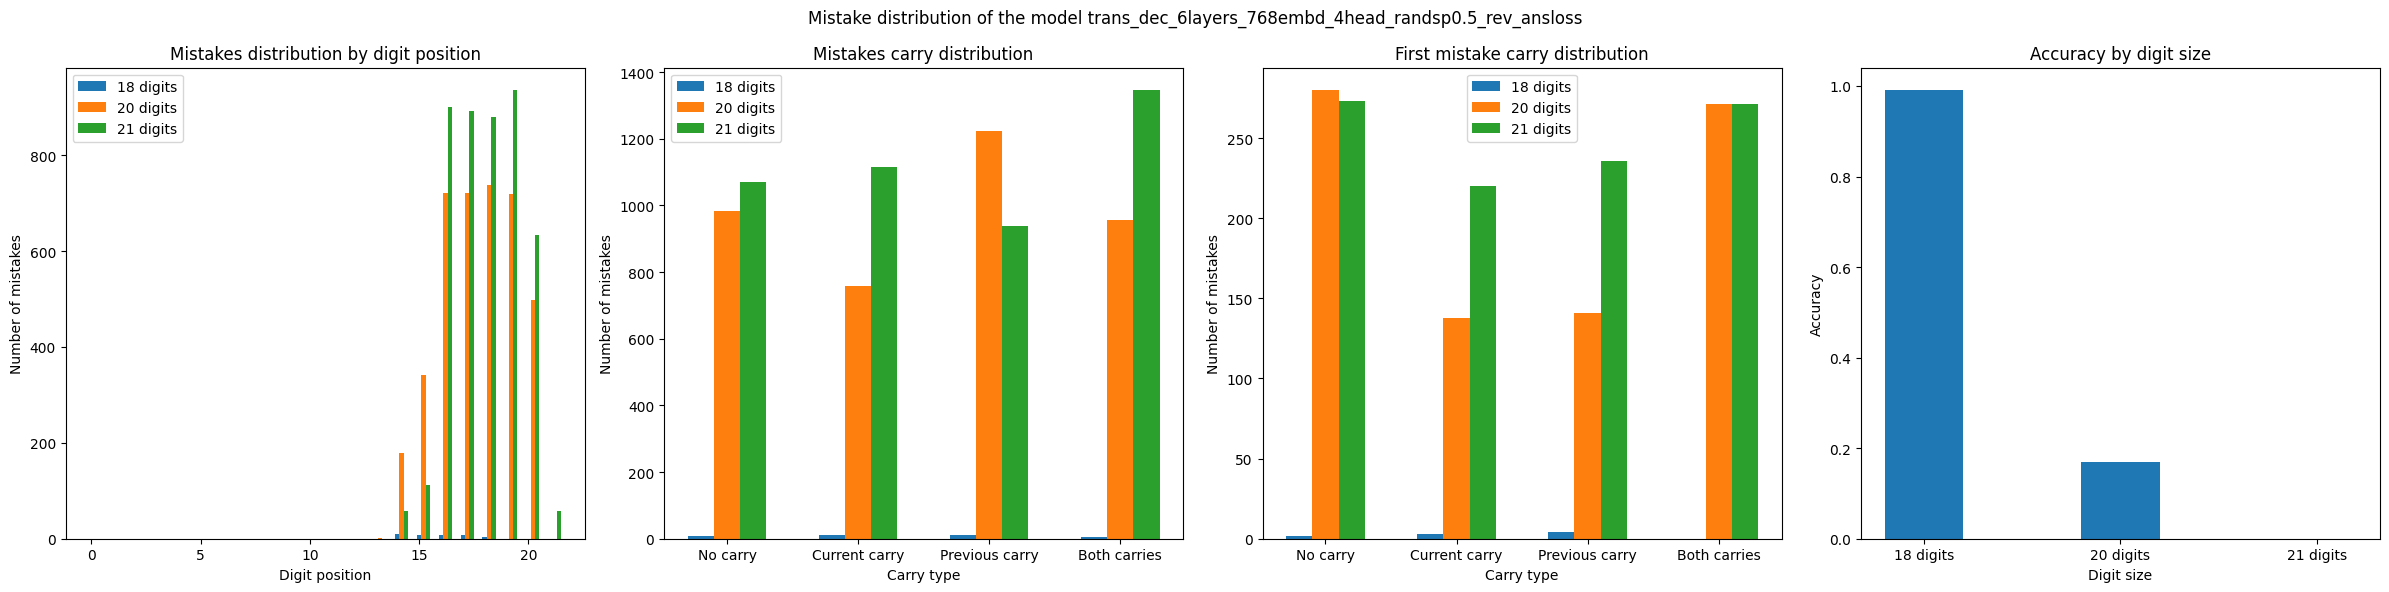

In [18]:
# Prepare data for plotting
digit_sizes = [result["n_digits"] for result in eval_res]
mistakes_by_position = [result["mistakes"] for result in eval_res]
mistake_carry = [result["mistake_carry"] for result in eval_res]
first_mistake_carry = [result["first_mistake_carry"] for result in eval_res]
accuracy = [result["accuracy"] for result in eval_res]

# Map for carry explanations
carry_explanations = {
    ".": "No carry",
    "c": "Current carry",
    "p": "Previous carry",
    "C": "Both carries",
}

# Plot results as grouped bar charts
fig, axs = plt.subplots(1, 4, figsize=(24, 6))

# Mistakes distribution by digit position
for i, mistakes in enumerate(mistakes_by_position):
    axs[0].bar(
        np.arange(len(mistakes)) + i * 0.2,
        mistakes,
        width=0.2,
        label=f"{digit_sizes[i]} digits",
    )
axs[0].set_xlabel("Digit position")
axs[0].set_ylabel("Number of mistakes")
axs[0].set_title("Mistakes distribution by digit position")
axs[0].legend()

# Mistakes carry distribution
carry_labels = list(carry_explanations.values())
for i, carry in enumerate(mistake_carry):
    axs[1].bar(
        np.arange(len(carry)) + i * 0.2,
        [carry[key] for key in carry_explanations.keys()],
        width=0.2,
        label=f"{digit_sizes[i]} digits",
    )
axs[1].set_xticks(np.arange(len(carry_labels)) + 0.2)
axs[1].set_xticklabels(carry_labels)
axs[1].set_xlabel("Carry type")
axs[1].set_ylabel("Number of mistakes")
axs[1].set_title("Mistakes carry distribution")
axs[1].legend()

# First mistake carry distribution
for i, carry in enumerate(first_mistake_carry):
    axs[2].bar(
        np.arange(len(carry)) + i * 0.2,
        [carry[key] for key in carry_explanations.keys()],
        width=0.2,
        label=f"{digit_sizes[i]} digits",
    )
axs[2].set_xticks(np.arange(len(carry_labels)) + 0.2)
axs[2].set_xticklabels(carry_labels)
axs[2].set_xlabel("Carry type")
axs[2].set_ylabel("Number of mistakes")
axs[2].set_title("First mistake carry distribution")
axs[2].legend()

# Accuracy plot
axs[3].bar(np.arange(len(accuracy)), accuracy, width=0.4)
axs[3].set_xticks(np.arange(len(accuracy)))
axs[3].set_xticklabels([f"{size} digits" for size in digit_sizes])
axs[3].set_xlabel("Digit size")
axs[3].set_ylabel("Accuracy")
axs[3].set_title("Accuracy by digit size")

# set fig title
fig.suptitle(f"Mistake distribution of the model {model_name}")

plt.tight_layout()
plt.savefig(
    PLOTS_DIR / "gen_to_longer_rand_spaces" / f"{model_name}_mistake_distribution.png"
)
plt.show()